<a href="https://colab.research.google.com/github/ItayG6454/Time-Series-Course/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df = pd.read_csv("/content/drive/MyDrive/1. Study/MSc/TimeSeries/Final Project/charts.csv")

In [26]:
df.sample(4)

,title,rank,date,artist,url,region,chart,trend,streams
17017073,DANCE,51,2020-07-30,"CLMD, Tungevaag",https://open.spotify.com/track/6TfeXwJihJRuBW3...,Norway,top200,MOVE_UP,22140.0
18813482,sao trông em lại như thế này,20,2020-12-19,"Negav, CROW ON HYENAS",https://open.spotify.com/track/4uEtp8xmFuV2aT9...,Vietnam,viral50,MOVE_DOWN,NaN
19576316,Taaron Ke Shehar,82,2021-05-18,"Neha Kakkar, Jubin Nautiyal, Jaani",https://open.spotify.com/track/1r6sFC5J0p9r3jc...,India,top200,MOVE_DOWN,51150.0
20414822,Take Me As I Am,15,2020-05-19,Tornike Kipiani,https://open.spotify.com/track/3sXZrgz3ibbszEj...,Sweden,viral50,SAME_POSITION,NaN


In [27]:
df['artist'].value_counts()[1:20]

artist
Billie Eilish      251825
Post Malone        211272
Bad Bunny          203403
Ariana Grande      189914
Dua Lipa           187085
Drake              177380
Imagine Dragons    157900
XXXTENTACION       155458
BTS                154338
The Weeknd         153292
Justin Bieber      130397
Travis Scott       122980
Juice WRLD         121933
Maluma             110762
Shawn Mendes       108786
Harry Styles       107539
Maroon 5           105610
Doja Cat           104325
Lewis Capaldi      101700
Name: count, dtype: int64

## Converting to weekly data

In [28]:
df['date'] = pd.to_datetime(df['date'])
df = df[df['chart'] == 'top200']
df = df[['rank', 'date', 'artist', 'region', 'streams']]
ed_glob_df = df[(df['region'] == 'Global') & (df['artist'] == 'Ed Sheeran')]
tmp = ed_glob_df[['date','streams']].groupby(['date']).sum().reset_index()
# Resample to weekly frequency and calculate the average of 'streams'
tmp.set_index('date', inplace=True)
weekly_streams = tmp.resample('W').sum()

In [ ]:
weekly_streams

## Part 2 -  Model Fitting

### Model 1 - Fourier Analysis


In [ ]:
N = len(weekly_streams)
T = 1 / 52  # Sampling period in weeks

# Compute Fourier Transform
y = weekly_streams['streams'].values
yf = np.fft.fft(y)
xf = np.fft.fftfreq(N, T)

print("Length of data (N):", N)
print("Size of Fourier coefficients array (yf):", yf.size)
print("Size of frequencies array (xf):", xf.size)
# print("Indices used:", indices)


<ipython-input-38-f95532c13117>:36: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax2.stem(xf[:N//2], np.abs(yf[:N//2]), use_line_collection=True)


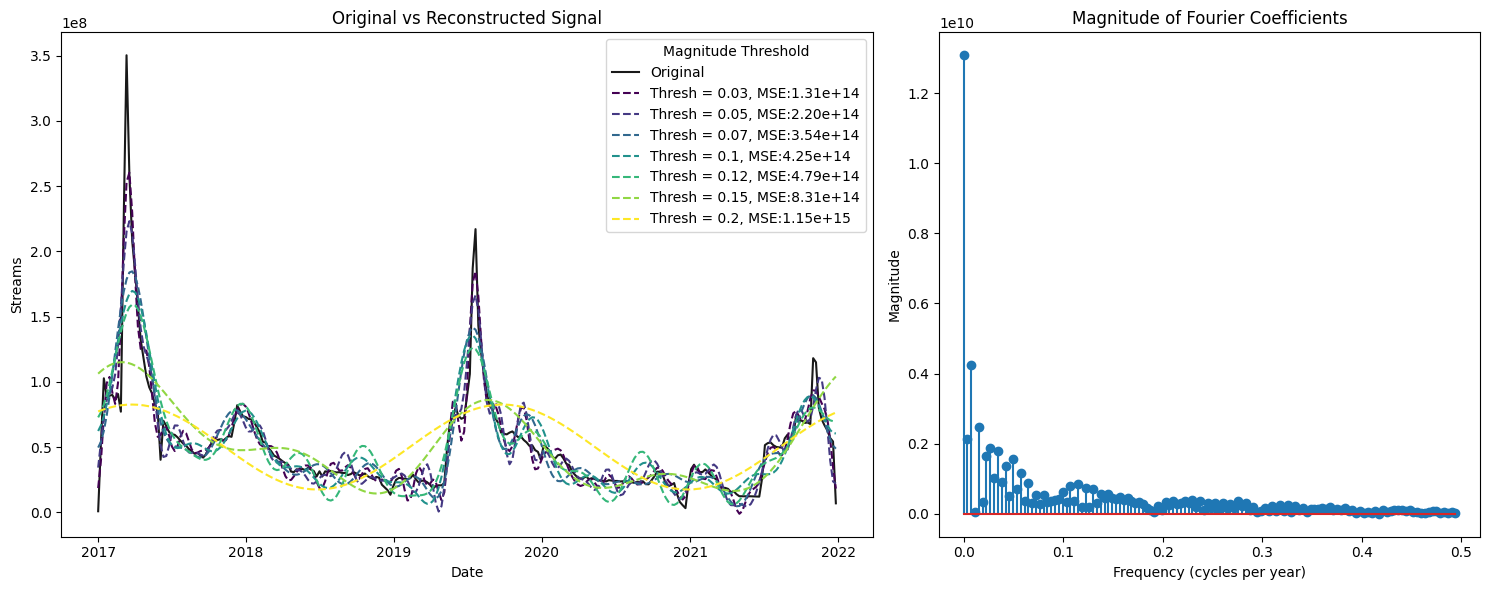

In [38]:
# Set up a grid layout
plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[60, 40])

# Plot original and reconstructed data
ax1 = plt.subplot(gs[0])
ax1.plot(weekly_streams.index, y, label='Original', alpha=0.9, color='black')

# Tuning magnitude threshold
thresholds = [0.03, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2]
colors = cm.viridis(np.linspace(0, 1, len(thresholds)))

for magnitude_threshold, color in zip(thresholds, colors):
    significant_indices = np.where(np.abs(yf) > magnitude_threshold * np.max(np.abs(yf)))[0]

    # Reconstruct time series with significant coefficients only
    reconstruction = np.zeros(N)
    for idx in significant_indices:
        amplitude = np.abs(yf[idx]) / N
        phase = np.angle(yf[idx])
        reconstruction += amplitude * np.cos(2 * np.pi * xf[idx] * np.arange(N) + phase)

    # Calculating MSE for prediction
    mse = np.mean((weekly_streams['streams'] - reconstruction)**2)

    ax1.plot(weekly_streams.index, reconstruction, label=f'Thresh = {magnitude_threshold}, MSE:{mse:.2e}', linestyle='--', color=color)

# Plot Series with recostruction
ax1.legend(title='Magnitude Threshold')
ax1.set_title("Original vs Reconstructed Signal")
ax1.set_xlabel("Date")
ax1.set_ylabel("Streams")

# Plot Fourier Coefficients
ax2 = plt.subplot(gs[1])
ax2.stem(xf[:N//2], np.abs(yf[:N//2]), use_line_collection=True)
ax2.set_title('Magnitude of Fourier Coefficients')
ax2.set_xlabel('Frequency (cycles per year)')
ax2.set_ylabel('Magnitude')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error

# Parameters
thresholds = [0.03, 0.05, 0.07, 0.1, 0.12, 0.15, 0.2]
initial_train_size = int(len(y) * 0.5)  # Start with 50% of data as training
validation_size = int(len(y) * 0.1)  # Each validation step uses the next 20% of data

# Placeholder for scores
scores = np.zeros(len(thresholds))

# Cross-validation loop
for i, threshold in enumerate(thresholds):
    mse_scores = []
    print(f"Threshold:{threshold}")
    for start in range(initial_train_size, len(y) - validation_size, validation_size):
        print(f"\tTraining based:0 --> {start}, Tesing based:{start} --> {start + validation_size}")
        # Define the training and validation indices
        train_indices = np.arange(0, start)
        val_indices = np.arange(start, start + validation_size)

        # Perform Fourier transformation only on training data
        yf_train = np.fft.fft(y[train_indices])
        xf_train = np.fft.fftfreq(len(train_indices), 1)

        # Filter coefficients based on threshold
        significant_indices = np.where(np.abs(yf_train) > threshold * np.max(np.abs(yf_train)))[0]
        reconstruction = np.zeros(len(val_indices))
        for idx in significant_indices:
            amplitude = np.abs(yf_train[idx]) / len(train_indices)
            phase = np.angle(yf_train[idx])
            reconstruction += amplitude * np.cos(2 * np.pi * xf_train[idx] * np.arange(len(val_indices)) + phase)

        # Calculate MSE for the validation segment
        mse = mean_squared_error(y[val_indices], reconstruction)
        mse_scores.append(mse)

    # Average MSE for this threshold
    scores[i] = np.mean(mse_scores)
    print(f'Threshold: {threshold:.2f}, Average MSE: {scores[i]:.5f}')

# Find the best threshold
best_threshold = thresholds[np.argmin(scores)]
print(f'Best threshold: {best_threshold:.2f}, Lowest MSE: {min(scores):.5f}')

# Optional: Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(thresholds, scores, marker='o')
plt.title('Walk-Forward Validation MSE vs. Magnitude Threshold')
plt.xlabel('Magnitude Threshold')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()


### Performing 2 months predicting using the Fourier model

First,remmeber that  we need to compute Fourier Transform on full dataset, we can use $y,xf,yf$ from before. \
So all we need is to use the treshold we found to subset the sagnificants coeefients of the fourier series:

In [ ]:
significant_indices = np.where(np.abs(yf) > 0.03 * np.max(np.abs(yf)))[0]
significant_indices

Predicting 2 months ahead:

In [ ]:
start_date = pd.to_datetime('2017-01-01')

end_date = pd.to_datetime('2021-12-31')
N = (end_date - start_date).days // 7 + 1

# Prediction length for the first two months of 2022 (approximately 9 weeks)
prediction_length = 9
reconstruction = np.zeros(N + prediction_length)
time_vector = np.arange(N + prediction_length)

# Your Fourier transform results, assuming `yf` for amplitudes and `xf` for frequencies
for idx in significant_indices:
    amplitude = np.abs(yf[idx]) / N
    phase = np.angle(yf[idx])
    reconstruction += amplitude * np.cos(2 * np.pi * xf[idx] * time_vector + phase)

# Create date range for both original and forecast data, weekly frequency
total_dates = pd.date_range(start=start_date, periods=N + prediction_length, freq='W')

# Plotting the original data and the forecast
plt.figure(figsize=(15, 6))
plt.plot(total_dates[:N], y, label='Original Data')  # Plot original data
plt.plot(total_dates[N:], reconstruction[-prediction_length:], label='Forecast', linestyle='--')  # Plot forecast
plt.legend()
plt.title('Original Data and 2-Month Forecast using Fourier Transform')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
